In [1]:
import fastf1
import numpy as np
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import sklearn 
import time 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [57]:
df1 = pd.read_csv("dataset/f1_data_combined.csv")
df2 = pd.read_csv("dataset/Race_Info.csv", sep=";")

df1["RaceKey"] = df1["RaceName"].str.strip() + "_" + df1["Year"].astype(str)
df2["RaceKey"] = df2["RaceName"].str.strip() + "_" + df2["Year"].astype(str)


In [49]:
if not {"RaceName", "Year"}.issubset(df1.columns):
    raise KeyError("❌ 'RaceName' and/or 'Year' are missing from df1")
if not {"RaceName", "Year"}.issubset(df2.columns):
    raise KeyError("❌ 'RaceName' and/or 'Year' are missing from df2")

In [59]:
df = pd.merge(
    df1,
    df2.drop(columns=["RaceName", "Year"]),  # drop duplicates so RaceKey is unique
    on="RaceKey",
    how="left",
    validate="m:1"  # many drivers to 1 race info
)

In [53]:
df.head()

,Driver,LapTime_FP1,Compound_FP1,SpeedST_FP1,SpeedFL_FP1,SpeedI1_FP1,SpeedI2_FP1,LongestStintCompound_FP1,LongestStintLaps_FP1,AvgLapTime_LongestStint_FP1,...,FastestPracticeTime,FastestQualifyingTime,FastestPracticeCompound,IsImputed_FP1,IsImputed_FP2,IsImputed_FP3,RaceKey,Laps,Laps_Done,Type of Track
0,BOT,90.009,0.0,5.0,1.0,6.0,8.0,0.0,9.0,91.891667,...,89.019,87.622,0.0,False,False,False,Saudi Arabian Grand Prix_2021,50.0,50.0,High
1,GAS,90.263,0.0,2.0,4.0,2.0,5.0,0.0,12.0,92.192800,...,88.715,88.125,1.0,False,False,False,Saudi Arabian Grand Prix_2021,50.0,50.0,High
2,GIO,90.318,0.0,8.0,6.0,2.0,10.0,1.0,10.0,93.519500,...,89.590,88.616,0.0,False,False,False,Saudi Arabian Grand Prix_2021,50.0,50.0,High
3,HAM,89.786,0.0,4.0,1.0,6.0,10.0,0.0,10.0,91.686250,...,88.314,87.511,2.0,False,False,False,Saudi Arabian Grand Prix_2021,50.0,50.0,High
4,LAT,91.821,0.0,4.0,2.0,2.0,7.0,2.0,9.0,92.959667,...,90.366,89.177,0.0,False,False,False,Saudi Arabian Grand Prix_2021,50.0,50.0,High


In [60]:
df.rename(columns={"Type of Track": "TrackType"}, inplace=True)

In [62]:
# categorize type of track column
type_track = {"Low": 0, "Medium": 1, "High": 2}
df['TrackType'] = df['TrackType'].map(type_track)
# laps to int
df['Laps'] = df['Laps'].astype(int)
df["Laps_Done"] = df["Laps_Done"].astype(int)

In [3]:
# REMOVE UNNECESSARY COLUMNS

# Remove unnecessary columns qualifying
colsToDrop = ["Q1_TopSpeedST", "Q1_AirTemp", "Q1_TrackTemp", "Q1_WindSpeed",
    "Q1_WindDirection", "Q1_Humidity", "Q1_Pressure",
    "Q2_TopSpeedST", "Q2_AirTemp", "Q2_TrackTemp", "Q2_WindSpeed",
    "Q2_WindDirection", "Q2_Humidity", "Q2_Pressure",
    "Q3_TopSpeedST", "Q3_AirTemp", "Q3_TrackTemp", "Q3_WindSpeed",
    "Q3_WindDirection", "Q3_Humidity", "Q3_Pressure"]

df.drop(columns=colsToDrop, inplace=True)

# Remove unnecessary columns practice sessions
colsToDrop = ["SpeedFL_FP1", "SpeedI1_FP1", "SpeedI2_FP1",
    "SpeedFL_FP2", "SpeedI1_FP2", "SpeedI2_FP2",
    "SpeedFL_FP3", "SpeedI1_FP3", "SpeedI2_FP3"]

df.drop(columns=colsToDrop, inplace=True)

colsToDrop = [
# Fastest Lap Weather (Practice Sessions)
    "AirTemp_FastestLap_FP1", "TrackTemp_FastestLap_FP1", "WindSpeed_FastestLap_FP1",
    "WindDirection_FastestLap_FP1", "Humidity_FastestLap_FP1", "Pressure_FastestLap_FP1",
    "AirTemp_FastestLap_FP2", "TrackTemp_FastestLap_FP2", "WindSpeed_FastestLap_FP2",
    "WindDirection_FastestLap_FP2", "Humidity_FastestLap_FP2", "Pressure_FastestLap_FP2",
    "AirTemp_FastestLap_FP3", "TrackTemp_FastestLap_FP3", "WindSpeed_FastestLap_FP3",
    "WindDirection_FastestLap_FP3", "Humidity_FastestLap_FP3", "Pressure_FastestLap_FP3",

    # Average Weather During Longest Stint
    "AvgAirTemp_LongestStint_FP1", "AvgTrackTemp_LongestStint_FP1", "AvgWindSpeed_LongestStint_FP1",
    "AvgWindDirection_LongestStint_FP1", "AvgHumidity_LongestStint_FP1", "AvgPressure_LongestStint_FP1",
    "AvgAirTemp_LongestStint_FP2", "AvgTrackTemp_LongestStint_FP2", "AvgWindSpeed_LongestStint_FP2",
    "AvgWindDirection_LongestStint_FP2", "AvgHumidity_LongestStint_FP2", "AvgPressure_LongestStint_FP2",
    "AvgAirTemp_LongestStint_FP3", "AvgTrackTemp_LongestStint_FP3", "AvgWindSpeed_LongestStint_FP3",
    "AvgWindDirection_LongestStint_FP3", "AvgHumidity_LongestStint_FP3", "AvgPressure_LongestStint_FP3"
]

df.drop(columns=colsToDrop, inplace=True)
   

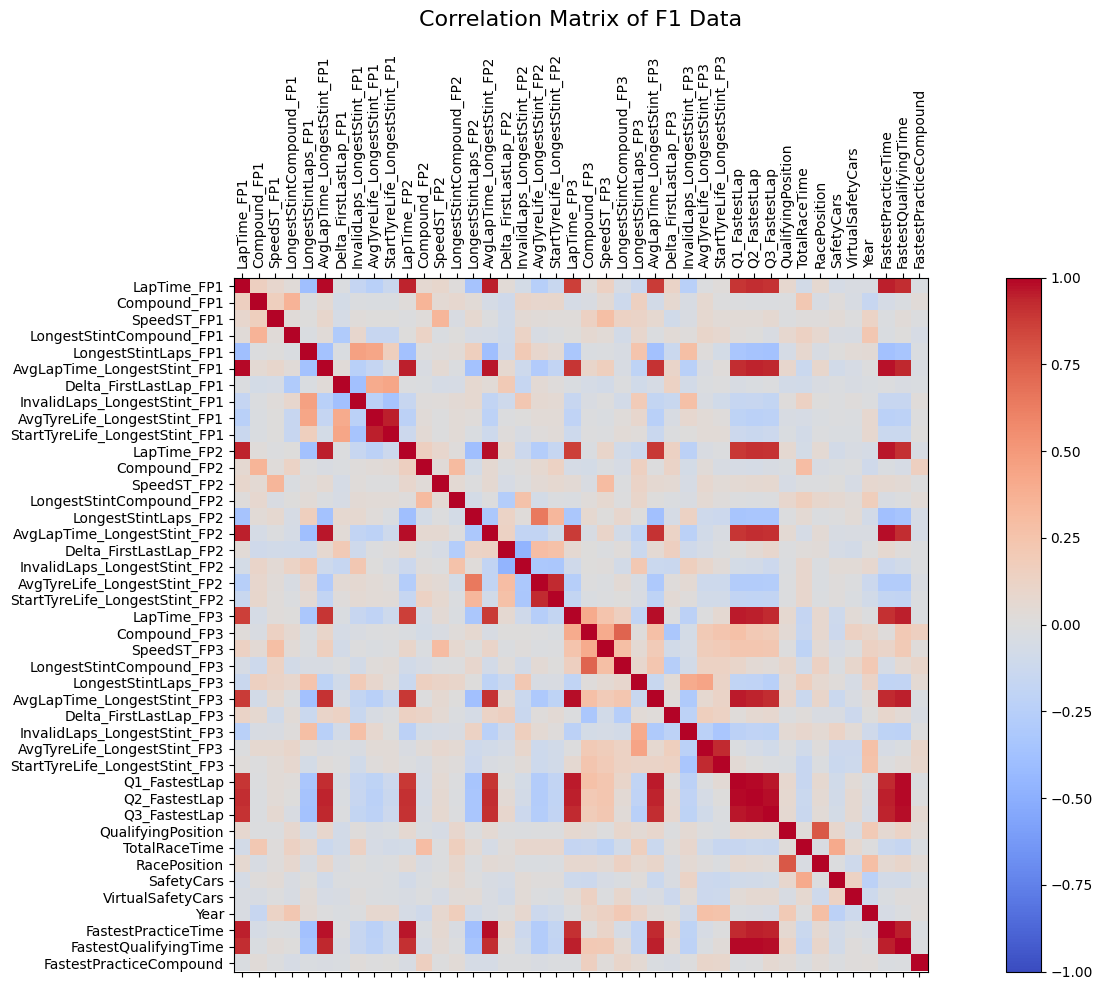

In [6]:
numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()
fig, ax = plt.subplots(figsize=(16, 10))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
corr['RacePosition'].sort_values(ascending=True)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
plt.title("Correlation Matrix of F1 Data", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

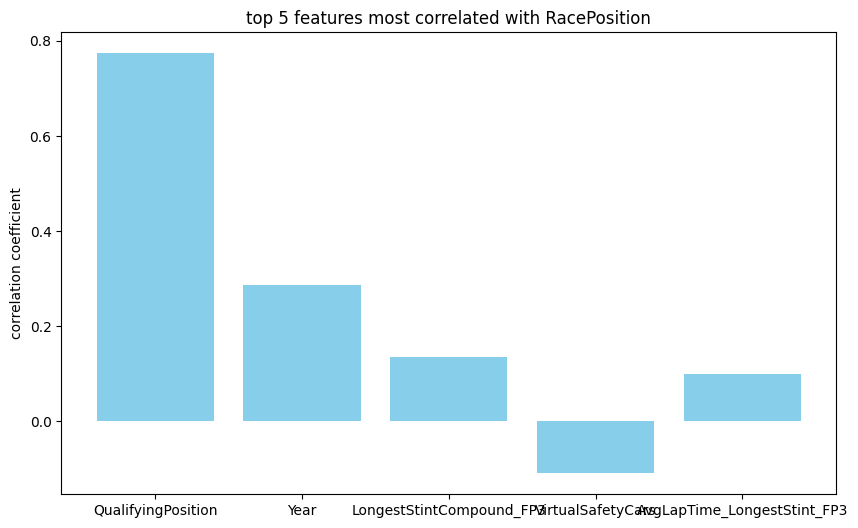

In [7]:
# most correlated features with RacePosition
corr_race = corr["RacePosition"]
corr_race = corr_race.drop("RacePosition")
sorted_corr = corr_race.abs().sort_values(ascending=False)
top5_features = sorted_corr.head(5).index
plt.figure(figsize=(10, 6))
plt.bar(top5_features, corr_race[top5_features], color='skyblue')
plt.ylabel("correlation coefficient")
plt.title("top 5 features most correlated with RacePosition")
plt.show()


In [8]:
# tried keeping only the stronger correlation values 
# there are so many values in the original matrix that it gets confusing
corr = df.corr(numeric_only=True)
threshold = 0.5
filtered_corr = corr.where(corr.abs() > threshold)
print(filtered_corr)


                                LapTime_FP1  Compound_FP1  SpeedST_FP1  \
LapTime_FP1                        1.000000           NaN          NaN   
Compound_FP1                            NaN           1.0          NaN   
SpeedST_FP1                             NaN           NaN          1.0   
LongestStintCompound_FP1                NaN           NaN          NaN   
LongestStintLaps_FP1                    NaN           NaN          NaN   
AvgLapTime_LongestStint_FP1        0.986577           NaN          NaN   
Delta_FirstLastLap_FP1                  NaN           NaN          NaN   
InvalidLaps_LongestStint_FP1            NaN           NaN          NaN   
AvgTyreLife_LongestStint_FP1            NaN           NaN          NaN   
StartTyreLife_LongestStint_FP1          NaN           NaN          NaN   
LapTime_FP2                        0.939838           NaN          NaN   
Compound_FP2                            NaN           NaN          NaN   
SpeedST_FP2                           

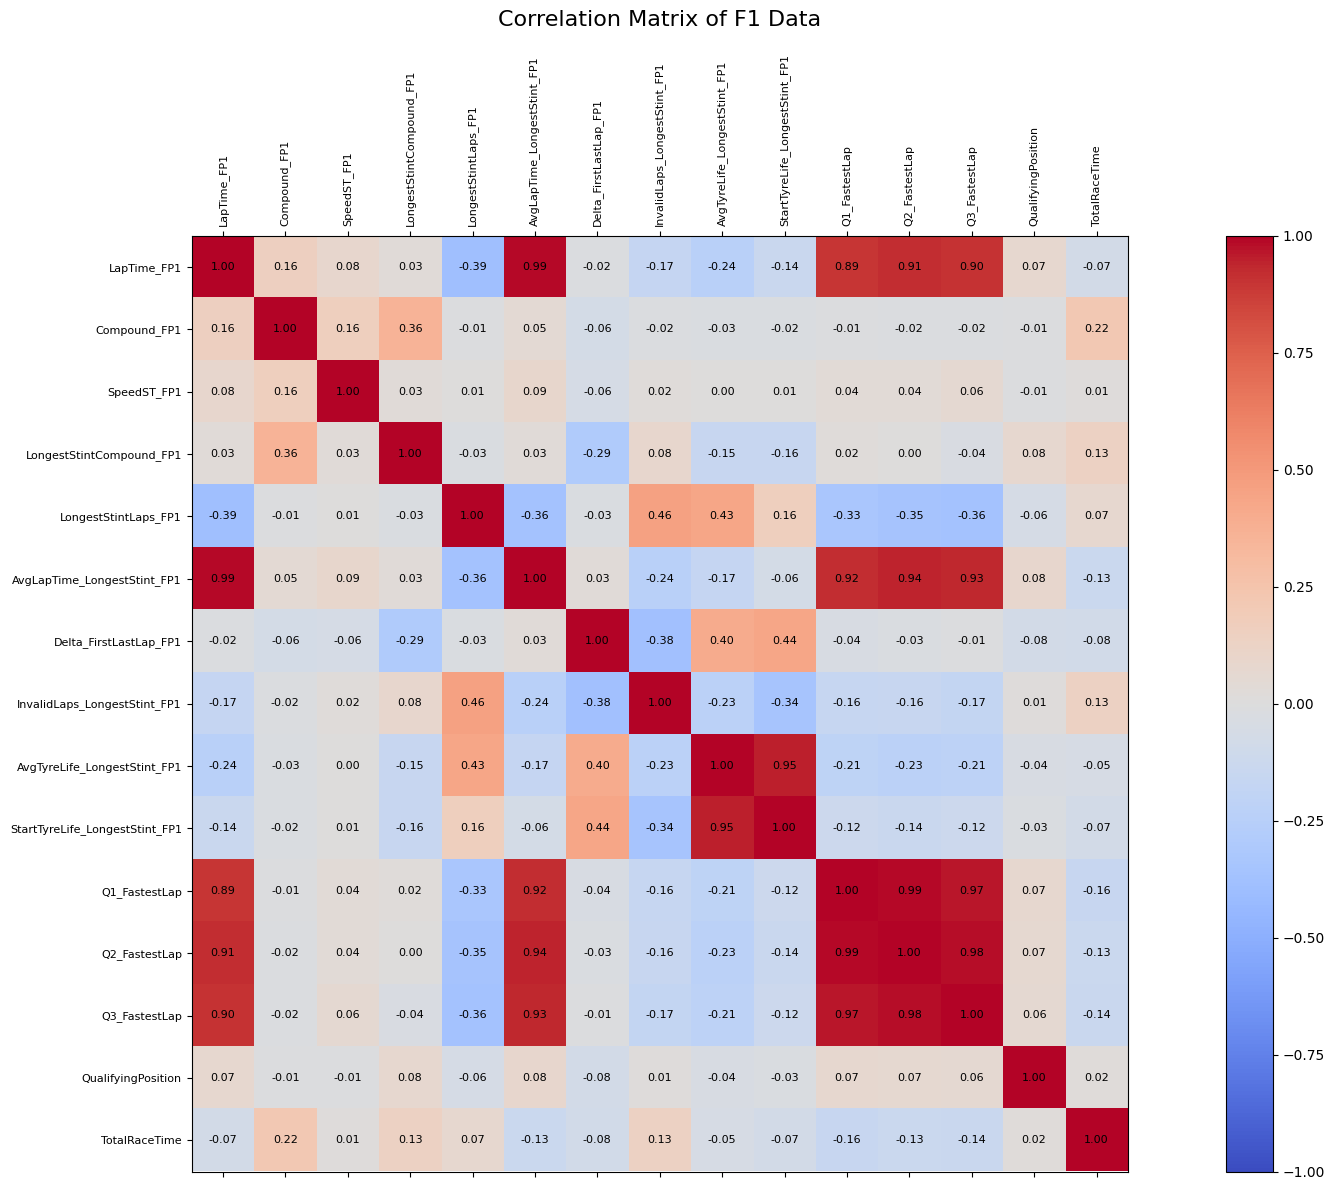

In [9]:
fp1_cols = df.columns[df.columns.str.contains('FP1')].tolist()
q_cols = df.columns[df.columns.str.contains('Q')].tolist()
q_cols_subset = q_cols[:4]
selected_cols = fp1_cols + q_cols_subset
filtered_df = df[selected_cols]
numeric_filtered_df = filtered_df.select_dtypes(include=['number'])
df["TotalRaceTime"] = pd.to_timedelta(df["TotalRaceTime"]).dt.total_seconds()
numeric_filtered_df["TotalRaceTime"] = df["TotalRaceTime"]


corr = numeric_filtered_df.corr()
fig, ax = plt.subplots(figsize=(20, 12))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90, fontsize = 8)
ax.set_yticklabels(corr.columns, fontsize = 8)
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        value = corr.iloc[i, j]
        ax.text(j, i, f"{value:.2f}", va='center', ha='center', color='black', fontsize=8)
plt.title("Correlation Matrix of F1 Data", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

XGB BOOST MODEL -> to deal with Nan value presence in the dataset
LINEAR REGRESSION -> impute missing values 

In [20]:
# Train test split
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
X = df.drop(columns=["TotalRaceTime", "RacePosition", "Driver", "TeamName", "RaceName", "Year", "FastestPracticeTime", "FastestQualifyingTime",
                     "FastestPracticeCompound", "IsImputed_FP1", "IsImputed_FP2", "IsImputed_FP3"])

y = df["TotalRaceTime"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# to remove the NaN values
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


In [22]:
model = LinearRegression()
model.fit(X_train_imputed, y_train)

y_pred = model.predict(X_test_imputed)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 1077043.24
